In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Extract basis of trends from Kepler Q14 (DR25) CBV file

In [23]:
J = 24   # number of cameras
N = 4    # number of trends per camera
K = 1000 # number of observations
B = np.ones((K,J,N+1)) # basis matrix - allow for 1 bias term per camera
t = np.arange(K)

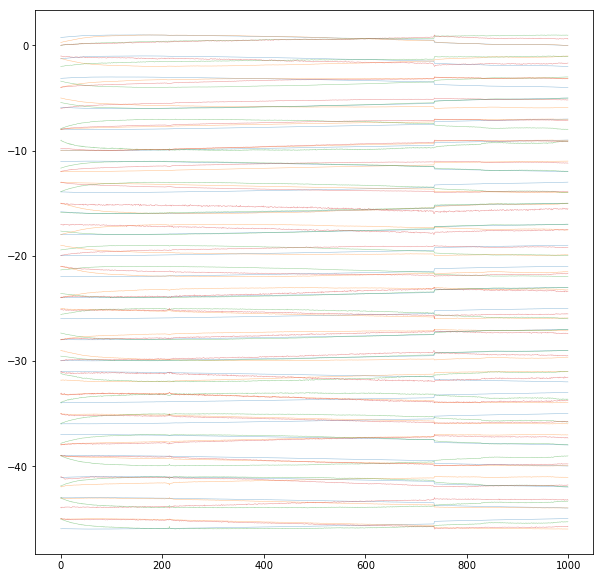

In [24]:
from astropy.io import fits as pf
hdul = pf.open('kplr2012277125453-q14-d25_lcbv.fits')
J_Kep = len(hdul)-1
j = 0
plt.figure(figsize=(10,10))
for jk in range(J_Kep):
    d = hdul[jk+1].data
    if len(d['VECTOR_1']) == 0: # empty MODOUT
        continue
    l = np.where(d['GAPFLAG'] == 0)[0][:K]
    for n in range(N):
        v = d['VECTOR_{}'.format(n+1)][l]
        vmin, vmax = np.nanmin(v), np.nanmax(v)
        v = (v-vmin) / (vmax-vmin)
        B[:,j,n] = v
        plt.plot(t,B[:,j,n]-2*j,'C{}-'.format(n),lw=0.5,alpha=0.5)
    j += 1
    if j == J: # that's enough
        break
hdul.close()

### Simulate stellar light curve (using QP GP)

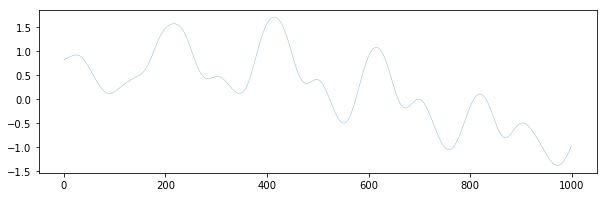

In [34]:
from george import kernels, GP
Period = 200
evol = 500
Gamma = 1.0
k = 1.0 * kernels.ExpSine2Kernel(gamma=Gamma,log_period=np.log(Period)) * \
    kernels.ExpSquaredKernel(metric=evol**2)
gp = GP(k)
y = gp.sample(t)
plt.figure(figsize=(10,3))
plt.plot(t,y,lw=0.5,alpha=0.5)

### Add transits

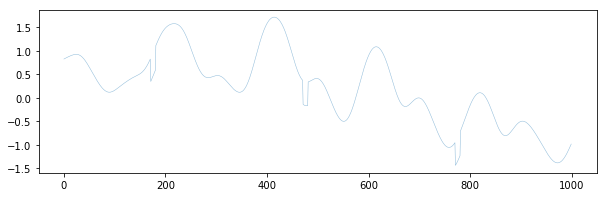

In [36]:
ptr = 300
t0tr = 175
dutr = 10
detr = 0.5
phtr = ((t-t0tr)%ptr)/ptr
phtr[phtr>0.5] -= 1
l = abs(phtr) <= (dutr/ptr/2)
y[l] -= detr
plt.figure(figsize=(10,3))
plt.plot(t,y,lw=0.5,alpha=0.5)

### Contruct J realisations of the light curve 
with different systematrics, white noise, and biases

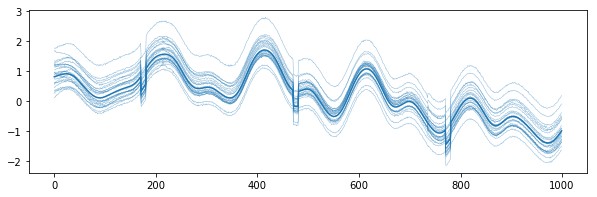

In [44]:
W = np.random.uniform(low=-0.5,high=0.5,size=(J,N+1))
sig = 0.01
f = np.zeros((K,J))
plt.figure(figsize=(10,3))
plt.plot(t,y,'C0-')
for j in range(J):
    f[:,j] = y + np.random.normal(scale=sig,size=K)
    for n in range(N+1):
        #print(j,n,W[j,n],np.nanmin(B[:,j,n]),np.nanmax(B[:,j,n]))
        f[:,j] += W[j,n] * B[:,j,n]
    plt.plot(t,f[:,j],'C0-',lw=0.5,alpha=.5)
